# arXiv heatmaps

We study the time-series linear models to make short-term predictions, following the sklearn [time-related feature engineering guide](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html).

First, we load the data from `data/arxiv-totals.parquet`.

In [1]:
import pandas as pd

df = pd.read_parquet("../data/arxiv-totals.parquet")

Later we will regress on the day of the week and the month: we extract and one-hot encode it.

In [2]:
from calendar import day_name

df.reset_index(inplace=True)
df["weekday"] = df["date"].apply(lambda date: day_name[date.weekday()])
df["month"] = df["date"].apply(lambda date: date.month)

one_hot_weekday = (
    pd.get_dummies(df.weekday, dtype=int).drop("Friday", axis=1).iloc[:, [0, 2, 3, 1]]
)
one_hot_month = pd.get_dummies(df.month, dtype=int).drop(12, axis=1)
df = df.join(one_hot_weekday).join(one_hot_month)

df.set_index("date", inplace=True)
df.columns = df.columns.astype(str)

Because the arXiv was still picking up, we have decided to ignore all dates before Jan 1, 2001.  We are also taking our training sample to end on Fri Mar 14, 2025 (included), and our testing sample to start from Mon Mar 17, 2025.

In [3]:
df_train = df[
    (df.index >= pd.Timestamp(2001, 1, 1)) & (df.index <= pd.Timestamp(2025, 3, 14))
]
df_test = df[df.index >= pd.Timestamp(2025, 3, 17)]

To get a sense of how these look like, we plot the submissions from the `math` category.

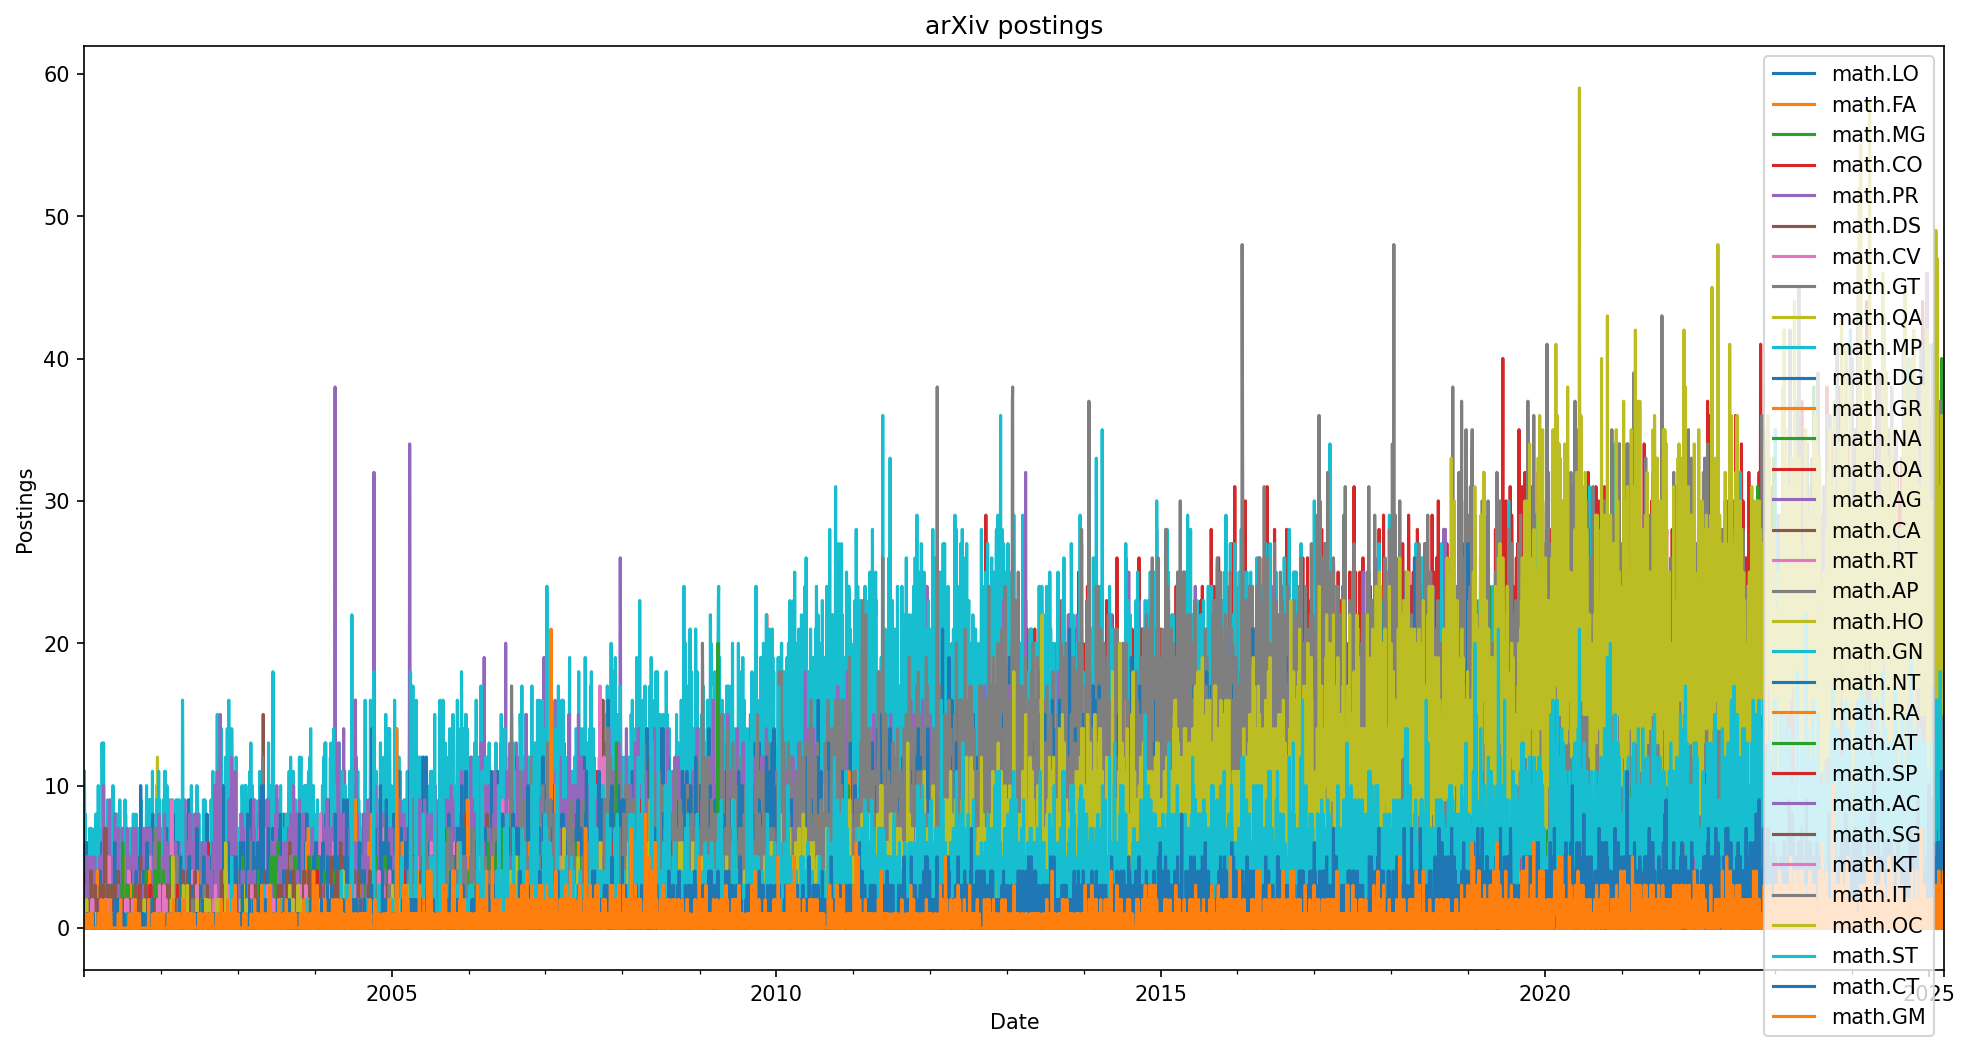

In [4]:
import matplotlib.pyplot as plt

# set plot size
plt.figure(figsize=(16, 8), dpi=150)

# adding the plots
for label, content in df_train.items():
    if label.startswith("math."):  # type: ignore
        content.plot(label=label)

# adding title to the plot
plt.title("arXiv postings")

# adding labels
plt.xlabel("Date")
plt.ylabel("Postings")

# adding legend to the curve
plt.legend()

We also plot `hep-ph` by itself.

Text(0, 0.5, 'Postings')

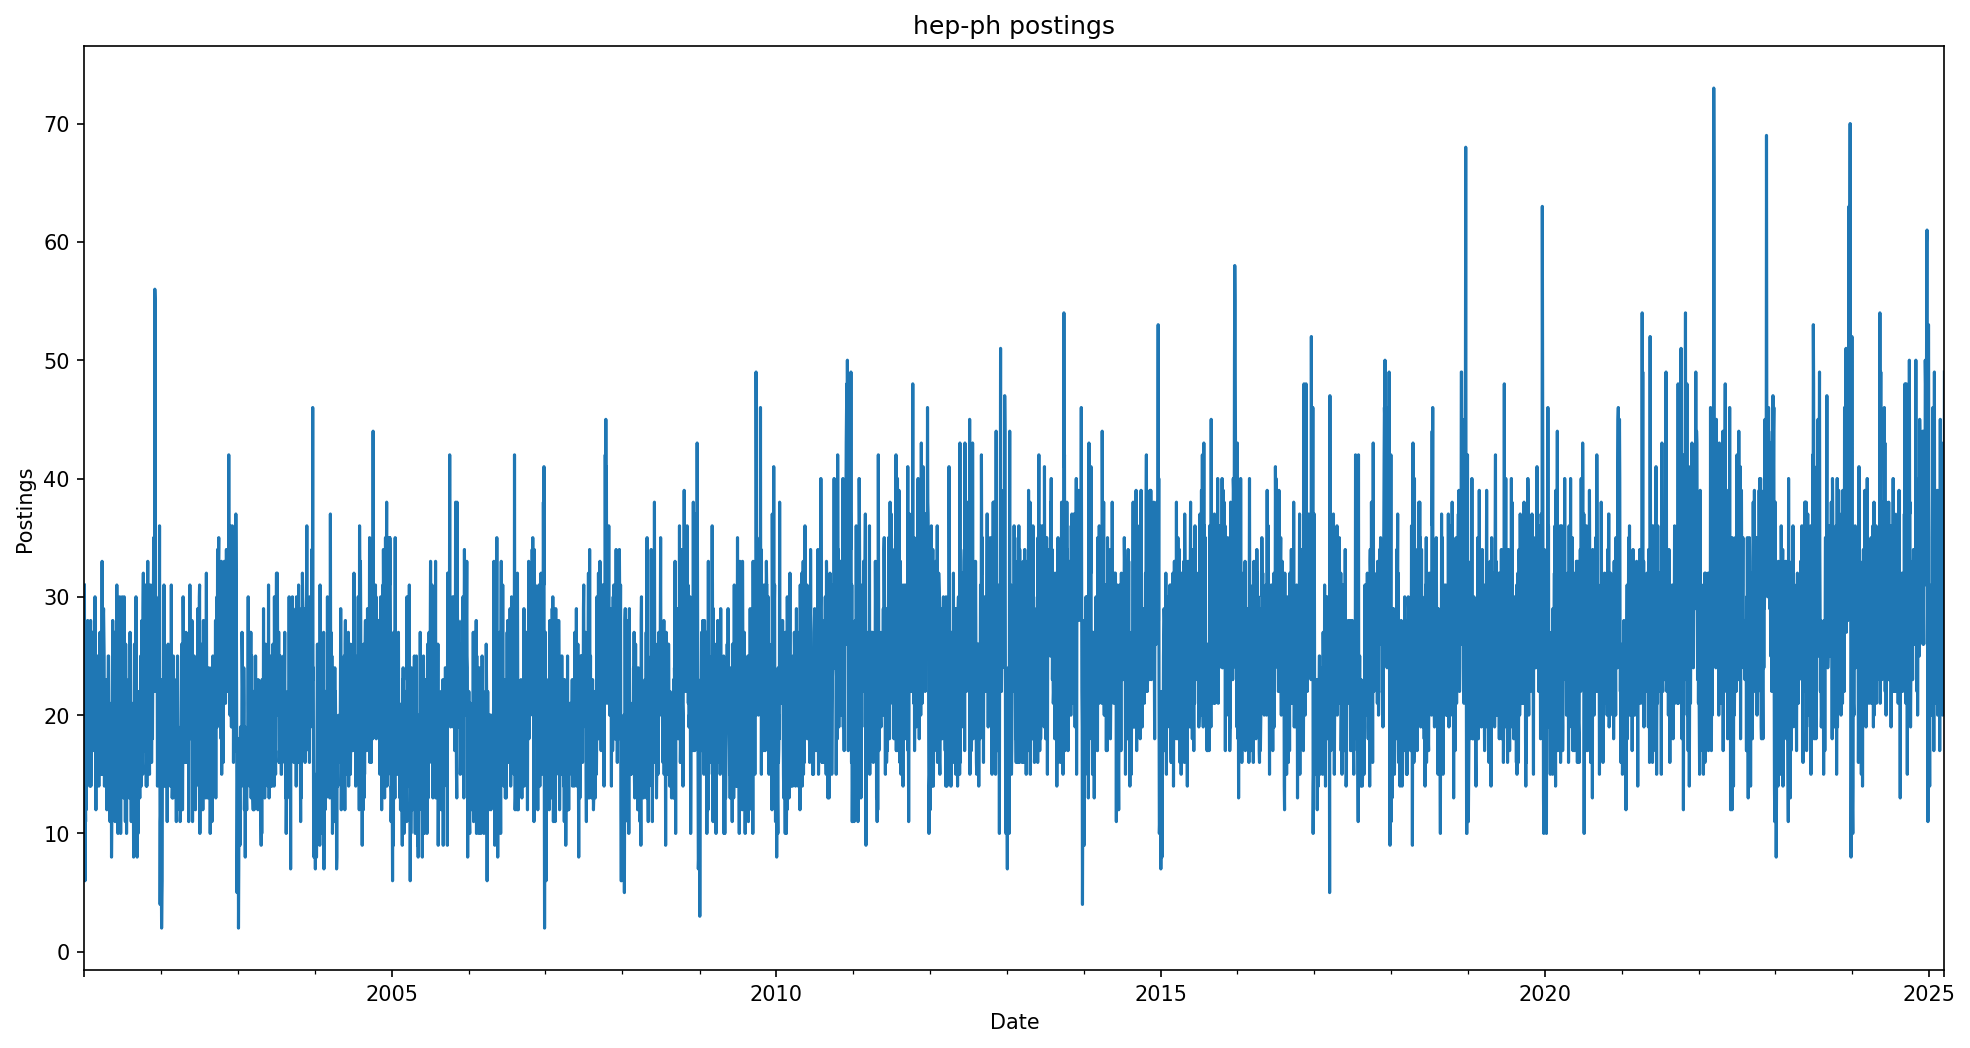

In [5]:
plt.figure(figsize=(16, 8), dpi=150)

df_train["hep-ph"].plot()

plt.title("hep-ph postings")
plt.xlabel("Date")
plt.ylabel("Postings")

We now prepare a 5-fold validation.  We take a gap of 5 business days between train and validation splits, and we take a test size of 15 business days (our forecasting horizon is 5 business days).

In [6]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5, test_size=15, max_train_size=150)

splits = list(ts_cv.split(df_train))

## Models comparison

The models we are going to compare are the following:
- `dummy`: predict the mean of the given window (150 days)
- `t_reg`: linearly regress in time only
- `day_reg`: linearly regress in the days of the week (as categorical feature)
- `mday_reg`: linearly regress in the days of the week and the month (as categorical features)
- `tday_reg`: linearly regress in time and day of the week
- `gbrt`: [gradient boosting](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#gradient-boosting) with categorical features `weekday` and `month`

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

import numpy as np

import json

dummy = DummyRegressor(strategy="mean")
t_reg = LinearRegression()
day_reg = LinearRegression()
mday_reg = LinearRegression()
tday_reg = LinearRegression()
gbrt = HistGradientBoostingRegressor(categorical_features=["weekday", "month"])

dummy_rmses = np.zeros(5)
t_rmses = np.zeros(5)
day_rmses = np.zeros(5)
mday_rmses = np.zeros(5)
tday_rmses = np.zeros(5)
gbrt_rmses = np.zeros(5)

with open("../data/arxiv-categories.json", "r") as f:
    arxiv_categories_descriptions = json.load(f)

categories = sorted(
    [cat["tag"] for cat in arxiv_categories_descriptions]
    # We exclude ["q-bio", "cond-mat", "astro-ph"] because they disappeared before our sample starting date.
)
results_dict = {}

for category in categories:
    for i, (train_index, test_index) in enumerate(splits):
        # prepare train data
        df_tt = df_train.iloc[train_index, :]
        df_tt.reset_index(inplace=True)
        df_tt.reset_index(
            inplace=True
        )  # reset index twice to get a column of indexes to use as feature

        # prepare validation data
        df_holdout = df_train.iloc[test_index, :]
        df_holdout.reset_index(inplace=True)
        df_holdout.reset_index(inplace=True)

        # dummy model
        dummy.fit(df_tt[["index"]], df_tt[category])
        dummy_preds = dummy.predict(df_holdout[["index"]])
        dummy_rmses[i] = root_mean_squared_error(df_holdout[category], dummy_preds)

        # t-linear model
        t_reg.fit(df_tt[["index"]], df_tt[category])
        t_preds = t_reg.predict(df_holdout[["index"]])
        t_rmses[i] = root_mean_squared_error(df_holdout[category], t_preds)

        # day-linear model
        day_reg.fit(
            df_tt[["Monday", "Tuesday", "Wednesday", "Thursday"]], df_tt[category]
        )
        day_preds = day_reg.predict(
            df_holdout[["Monday", "Tuesday", "Wednesday", "Thursday"]]
        )
        day_rmses[i] = root_mean_squared_error(df_holdout[category], day_preds)

        # day-linear model
        mday_reg.fit(
            df_tt[
                [
                    "1",
                    "2",
                    "3",
                    "4",
                    "5",
                    "6",
                    "7",
                    "8",
                    "9",
                    "10",
                    "11",
                    "Monday",
                    "Tuesday",
                    "Wednesday",
                    "Thursday",
                ]
            ],
            df_tt[category],
        )
        mday_preds = mday_reg.predict(
            df_holdout[
                [
                    "1",
                    "2",
                    "3",
                    "4",
                    "5",
                    "6",
                    "7",
                    "8",
                    "9",
                    "10",
                    "11",
                    "Monday",
                    "Tuesday",
                    "Wednesday",
                    "Thursday",
                ]
            ]
        )
        mday_rmses[i] = root_mean_squared_error(df_holdout[category], mday_preds)

        # tday-linear model
        tday_reg.fit(
            df_tt[["index", "Monday", "Tuesday", "Wednesday", "Thursday"]],
            df_tt[category],
        )
        tday_preds = tday_reg.predict(
            df_holdout[["index", "Monday", "Tuesday", "Wednesday", "Thursday"]]
        )
        tday_rmses[i] = root_mean_squared_error(df_holdout[category], tday_preds)

        # gradient boosting
        gbrt.fit(df_tt[["weekday", "month"]], df_tt[category])
        gbrt_preds = gbrt.predict(df_holdout[["weekday", "month"]])
        gbrt_rmses[i] = root_mean_squared_error(df_holdout[category], gbrt_preds)

    # Different categories have widely different posting rates. To account for
    # that, we rescale the rmses by the max of the category in the training set
    results_dict[category] = (
        np.array(
            [
                dummy_rmses.mean(),
                t_rmses.mean(),
                day_rmses.mean(),
                mday_rmses.mean(),
                tday_rmses.mean(),
                gbrt_preds.mean(),
            ]
        )
        / df_train[category].max()
    )

results = (
    pd.DataFrame(results_dict)
    .join(
        pd.DataFrame(
            {"model": ["dummy", "t_reg", "day_reg", "mday_reg", "tday_reg", "gbrt"]}
        )
    )
    .set_index("model")
    .transpose()
)

In [8]:
results

model,dummy,t_reg,day_reg,mday_reg,tday_reg,gbrt
astro-ph.CO,0.114295,0.114411,0.103864,0.130049,0.104149,0.372266
astro-ph.EP,0.145393,0.149067,0.142077,0.145055,0.145662,0.322899
astro-ph.GA,0.180691,0.176980,0.173878,0.201720,0.170323,0.533498
astro-ph.HE,0.080864,0.080653,0.076235,0.087868,0.075990,0.236913
astro-ph.IM,0.131118,0.138668,0.124491,0.126522,0.131551,0.316229
...,...,...,...,...,...,...
stat.CO,0.159018,0.158214,0.155274,0.168746,0.153934,0.341964
stat.ME,0.171025,0.172370,0.133630,0.145238,0.136098,0.436570
stat.ML,0.053101,0.056254,0.039503,0.042710,0.043714,0.116026
stat.OT,0.138878,0.137946,0.139301,0.143126,0.138516,0.155705


In [9]:
results.to_csv("short-term-linear-scaled-results.csv")

All models are faring pretty poorly, with a marginal improvement with regression on weekdays, which has the lowest average root mean squared error for approximately 40% of the categories.

In [10]:
results.mean()

model
dummy       0.133979
t_reg       0.136332
day_reg     0.122965
mday_reg    0.128091
tday_reg    0.125551
gbrt        0.271868
dtype: float64

In [11]:
day_is_best = []
for index, content in results.iterrows():
    if content.min() == content["day_reg"]:
        day_is_best.append(index)

print(
    "Regression on weekdays is the best model for",
    len(day_is_best) / len(categories) * 100,
    "% of the categories.",
)
print()
print("The categories are the following:")
for cat in day_is_best:
    print("    -", cat)

Regression on weekdays is the best model for 43.225806451612904 % of the categories.

The categories are the following:
    - astro-ph.CO
    - astro-ph.EP
    - astro-ph.IM
    - cond-mat.dis-nn
    - cond-mat.mes-hall
    - cond-mat.mtrl-sci
    - cond-mat.other
    - cond-mat.quant-gas
    - cond-mat.soft
    - cond-mat.str-el
    - cs.AR
    - cs.CE
    - cs.CR
    - cs.CY
    - cs.DB
    - cs.DC
    - cs.DM
    - cs.ET
    - cs.GT
    - cs.IT
    - cs.LG
    - cs.MM
    - cs.NE
    - cs.NI
    - cs.PF
    - cs.SE
    - cs.SI
    - econ.EM
    - econ.GN
    - econ.TH
    - eess.IV
    - eess.SP
    - hep-ex
    - hep-lat
    - math-ph
    - math.AC
    - math.AG
    - math.AP
    - math.CA
    - math.CO
    - math.CT
    - math.CV
    - math.DG
    - math.FA
    - math.GT
    - math.IT
    - math.KT
    - math.MP
    - math.OC
    - math.RT
    - math.SP
    - math.ST
    - nlin.SI
    - nucl-ex
    - physics.comp-ph
    - physics.gen-ph
    - physics.geo-ph
    - physics.hist-ph
 